In [9]:
import io
import os
import gzip
import math
import random
import urllib.request
from collections import defaultdict
from typing import Dict, List, Tuple
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import matplotlib.pyplot as plt


def set_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def load_snap_cagrqc() -> nx.Graph:
    with urllib.request.urlopen("https://snap.stanford.edu/data/ca-GrQc.txt.gz") as resp:
        raw = resp.read()
    buf = io.BytesIO(raw)
    with gzip.GzipFile(fileobj=buf) as f:
        lines = f.read().decode("utf-8").splitlines()

    edges = []
    for line in lines:
        if line.startswith("#") or not line.strip():
            continue
        u, v = line.strip().split()
        edges.append((u, v))

    G = nx.Graph()
    G.add_edges_from(edges)
    G.remove_edges_from(nx.selfloop_edges(G))
    G = nx.Graph(G)
    print(f"[data] SNAP ca-GrQc: |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")
    return G



def split_edges_for_link_prediction(G: nx.Graph, test_ratio: float = 0.1, seed: int = 42):
    rng = np.random.default_rng(seed)
    edges = list(G.edges())
    rng.shuffle(edges)
    n_test = int(len(edges) * test_ratio)
    test_pos = edges[:n_test]
    train_pos = edges[n_test:]

    G_train = G.copy()
    G_train.remove_edges_from(test_pos)

    # Негативные
    all_nodes = list(G.nodes())
    existent = set((min(u, v), max(u, v)) for u, v in G.edges())
    def sample_neg(m):
        neg = set()
        tries = 0
        max_tries = m * 20
        while len(neg) < m and tries < max_tries:
            u = rng.choice(all_nodes)
            v = rng.choice(all_nodes)
            if u == v:
                tries += 1
                continue
            a, b = (u, v) if u < v else (v, u)
            if (a, b) not in existent:
                neg.add((a, b))
            tries += 1
        if len(neg) < m:
            for i, u in enumerate(all_nodes):
                for v in all_nodes[i+1:]:
                    a, b = u, v
                    if (a, b) not in existent:
                        neg.add((a, b))
                        if len(neg) == m:
                            break
                if len(neg) == m: break
        return list(neg)

    train_neg = sample_neg(len(train_pos))
    test_neg  = sample_neg(len(test_pos))

    return G_train, train_pos, train_neg, test_pos, test_neg


def deepwalk_walk(G: nx.Graph, start, walk_length: int, rng: np.random.Generator) -> List:
    walk = [start]
    for _ in range(walk_length-1):
        cur = walk[-1]
        nbrs = list(G.neighbors(cur))
        if not nbrs:
            break
        nxt = rng.choice(nbrs)
        walk.append(nxt)
    return walk


def preprocess_transition_probs_node2vec(G: nx.Graph, p: float, q: float):
    def alias_setup(probs):
        K = len(probs)
        q = np.zeros(K)
        J = np.zeros(K, dtype=np.int32)
        smaller, larger = [], []
        for i, prob in enumerate(probs):
            q[i] = K * prob
            if q[i] < 1.0:
                smaller.append(i)
            else:
                larger.append(i)
        while smaller and larger:
            small = smaller.pop()
            large = larger.pop()
            J[small] = large
            q[large] = q[large] - (1.0 - q[small])
            if q[large] < 1.0:
                smaller.append(large)
            else:
                larger.append(large)
        return J, q

    def alias_draw(J, q, rng: np.random.Generator):
        K = len(J)
        kk = int(np.floor(rng.random() * K))
        if rng.random() < q[kk]:
            return kk
        else:
            return J[kk]

    # Первый шаг равномерный
    first_probs = {}
    for v in G.nodes():
        nbrs = list(G.neighbors(v))
        if not nbrs:
            continue
        probs = [1.0/len(nbrs)] * len(nbrs)
        first_probs[v] = (nbrs, *alias_setup(probs))

    # Второй+ шаг: зависят от (t, v)
    second_probs = {}
    for v in G.nodes():
        v_nbrs = list(G.neighbors(v))
        if not v_nbrs:
            continue
        for t in v_nbrs:
            unnorm = []
            for x in v_nbrs:
                if x == t:
                    weight = 1.0 / p
                elif x in G.neighbors(t):
                    weight = 1.0
                else:
                    weight = 1.0 / q
                unnorm.append(weight)
            s = float(sum(unnorm))
            probs = [w/s for w in unnorm]
            second_probs[(t, v)] = (v_nbrs, *alias_setup(probs))

    return first_probs, second_probs, alias_draw


def node2vec_walk(G: nx.Graph, start, walk_length: int,
                  first_probs, second_probs, alias_draw, rng: np.random.Generator):
    walk = [start]
    if walk_length == 1:
        return walk
    nbrs, J, q = first_probs.get(start, ([], None, None))
    if not nbrs:
        return walk
    idx = alias_draw(J, q, rng)
    v = nbrs[idx]
    walk.append(v)
    for _ in range(walk_length-2):
        t = walk[-2]
        v = walk[-1]
        key = (t, v)
        if key not in second_probs:
            break
        nbrs, J, q = second_probs[key]
        if not nbrs:
            break
        idx = alias_draw(J, q, rng)
        walk.append(nbrs[idx])
    return walk

def rooted_walks(G: nx.Graph, walk_length: int, walks_per_node: int,
                 strategy: str = "deepwalk", p: float = 1.0, q: float = 1.0,
                 seed: int = 42) -> Dict[str, List[List]]:
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    res = {u: [] for u in nodes}
    if strategy == "node2vec":
        first_probs, second_probs, alias_draw = preprocess_transition_probs_node2vec(G, p, q)
    for u in nodes:
        for _ in range(walks_per_node):
            if strategy == "deepwalk":
                w = deepwalk_walk(G, u, walk_length, rng)
            else:
                w = node2vec_walk(G, u, walk_length, first_probs, second_probs, alias_draw, rng)
            res[u].append(w)
    return res

def root_multiset_and_pairs(rooted: Dict[str, List[List]],
                            include_root: bool = False,
                            use_frequency: bool = True,
                            cap: int | None = None):

    multiset = defaultdict(lambda: defaultdict(int))
    for u, walks in rooted.items():
        for w in walks:
            start = 0 if include_root else 1
            for v in w[start:]:
                if (not include_root) and v == u:
                    continue
                multiset[u][v] += 1

    pairs = []
    if use_frequency:
        for u, d in multiset.items():
            for v, c in d.items():
                k = c if cap is None else min(c, cap)
                pairs.extend([(u, v)] * k)
    else:
        for u, d in multiset.items():
            for v in d.keys():
                pairs.append((u, v))
    return multiset, pairs


class AliasSampler:
    def __init__(self, probs: np.ndarray):
        K = len(probs)
        self.J = np.zeros(K, dtype=np.int32)
        self.q = np.zeros(K)
        smaller, larger = [], []
        for i, p in enumerate(probs):
            self.q[i] = K * p
            if self.q[i] < 1.0:
                smaller.append(i)
            else:
                larger.append(i)
        while smaller and larger:
            s = smaller.pop()
            l = larger.pop()
            self.J[s] = l
            self.q[l] -= (1.0 - self.q[s])
            if self.q[l] < 1.0:
                smaller.append(l)
            else:
                larger.append(l)

    def draw(self, rng: np.random.Generator, size: int) -> np.ndarray:
        K = len(self.J)
        kk = (rng.random(size) * K).astype(np.int64)
        prob = rng.random(size)
        use_k = prob < self.q[kk]
        out = kk.copy()
        out[~use_k] = self.J[kk[~use_k]]
        return out


def negative_sampler_for_graph(G: nx.Graph, id_of: Dict[str, int]) -> AliasSampler:
    deg = np.zeros(len(id_of), dtype=np.float64)
    for u in G.nodes():
        deg[id_of[u]] = G.degree[u]
    probs = deg / max(deg.sum(), 1e-12)
    probs = np.where(probs > 0, probs, 1e-12)
    probs = probs / probs.sum()
    return AliasSampler(probs)


class SGNS(nn.Module):
    def __init__(self, n_nodes: int, dim: int):
        super().__init__()
        self.in_emb = nn.Embedding(n_nodes, dim)
        self.out_emb = nn.Embedding(n_nodes, dim)
        nn.init.uniform_(self.in_emb.weight, a=-0.5/dim, b=0.5/dim)
        nn.init.uniform_(self.out_emb.weight, a=-0.5/dim, b=0.5/dim)

    def forward(self, center_ids: torch.LongTensor, pos_ids: torch.LongTensor,
                neg_ids: torch.LongTensor):

        z_c = self.in_emb(center_ids)
        z_p = self.out_emb(pos_ids)
        pos_score = torch.sum(z_c * z_p, dim=1)
        pos_loss = -torch.log(torch.sigmoid(pos_score) + 1e-12).mean()

        z_n = self.out_emb(neg_ids)
        neg_score = torch.einsum("bd,bkd->bk", z_c, z_n)
        neg_loss = -torch.log(torch.sigmoid(-neg_score) + 1e-12).mean()

        return pos_loss + neg_loss

    def embeddings(self) -> torch.Tensor:
        return (self.in_emb.weight + self.out_emb.weight) / 2.0


def train_sgns_from_pairs(pairs: List[Tuple[str, str]],
                          nodes: List[str],
                          id_of: Dict[str, int],
                          neg_sampler: AliasSampler,
                          dim: int = 128,
                          neg_k: int = 5,
                          epochs: int = 3,
                          batch_size: int = 1024,
                          lr: float = 0.0001,
                          seed: int = 42,
                          device=None) -> np.ndarray:
    set_seeds(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[train] SGNS on {len(pairs):,} positive pairs; neg_k={neg_k}, dim={dim}, epochs={epochs}, batch_size={batch_size}, device={device}")

    model = SGNS(n_nodes=len(nodes), dim=dim).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), weight_decay=0.0)

    rng = np.random.default_rng(seed)
    centers = np.fromiter((id_of[u] for (u, v) in pairs), dtype=np.int64)
    pos = np.fromiter((id_of[v] for (u, v) in pairs), dtype=np.int64)

    n = len(centers)
    steps_per_epoch = math.ceil(n / batch_size)

    for epoch in range(1, epochs+1):
        order = rng.permutation(n)
        centers = centers[order]
        pos = pos[order]
        running = 0.0
        bar = tqdm(range(steps_per_epoch), desc=f"[epoch {epoch}]")
        for step in bar:
            s = step * batch_size
            e = min(n, s + batch_size)
            c_batch = torch.from_numpy(centers[s:e]).long().to(device)
            p_batch = torch.from_numpy(pos[s:e]).long().to(device)

            neg_idx = neg_sampler.draw(rng, size=(e - s) * neg_k)
            neg_idx = neg_idx.reshape(e - s, neg_k)
            n_batch = torch.from_numpy(neg_idx).long().to(device)

            loss = model(c_batch, p_batch, n_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()

            running = 0.9 * running + 0.1 * float(loss.item()) if step > 0 else float(loss.item())
            bar.set_postfix({"loss": f"{running:.4f}"})

    with torch.no_grad():
        emb = model.embeddings().cpu().numpy()
    return emb


def edge_features_hadamard(emb: np.ndarray, id_of: Dict[str, int],
                           edges: List[Tuple[str, str]]) -> np.ndarray:
    X = np.empty((len(edges), emb.shape[1]), dtype=np.float32)
    for i, (u, v) in enumerate(edges):
        X[i] = emb[id_of[u]] * emb[id_of[v]]
    return X


def run_pipeline(G_train: nx.Graph,
                 full_G: nx.Graph,
                 train_pos, train_neg, test_pos, test_neg,
                 strategy: str,
                 walk_length: int, walks_per_node: int, window: int,
                 dim: int, neg_k: int, epochs: int, batch_size: int,
                 p: float, q: float,
                 seed: int = 42):

    rooted = rooted_walks(G_train, walk_length, walks_per_node,
                      strategy=strategy, p=p, q=q, seed=seed)
    _, pairs = root_multiset_and_pairs(rooted, include_root=False, use_frequency=True, cap=None)

    nodes = list(G_train.nodes())
    id_of = {u: i for i, u in enumerate(nodes)}

    neg_sampler = negative_sampler_for_graph(G_train, id_of)

    emb = train_sgns_from_pairs(
        pairs=pairs, nodes=nodes, id_of=id_of, neg_sampler=neg_sampler,
        dim=dim, neg_k=neg_k, epochs=epochs, batch_size=batch_size, seed=seed
    )

    def filter_edges(edges):
        return [(u, v) for (u, v) in edges if u in id_of and v in id_of]

    train_pos_f = filter_edges(train_pos)
    train_neg_f = filter_edges(train_neg)
    test_pos_f  = filter_edges(test_pos)
    test_neg_f  = filter_edges(test_neg)

    X_train = np.vstack([
        edge_features_hadamard(emb, id_of, train_pos_f),
        edge_features_hadamard(emb, id_of, train_neg_f)
    ])
    y_train = np.hstack([np.ones(len(train_pos_f)), np.zeros(len(train_neg_f))])

    X_test = np.vstack([
        edge_features_hadamard(emb, id_of, test_pos_f),
        edge_features_hadamard(emb, id_of, test_neg_f)
    ])
    y_test = np.hstack([np.ones(len(test_pos_f)), np.zeros(len(test_neg_f))])

    clf = LogisticRegression(max_iter=2000, n_jobs=None)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_prob)
    ap  = average_precision_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    return {"emb": emb, "id_of": id_of, "auc": auc, "ap": ap, "acc": acc}

In [10]:
dim = 128
walk_length = 40
walks_per_node = 20
window = 10
neg_k = 10
epochs = 1
batch_size = 2048
p = 1.0
q = 0.5
seed = 42
test_ratio = 0.1

set_seeds(seed)
G = load_snap_cagrqc()

G_train, tr_pos, tr_neg, te_pos, te_neg = split_edges_for_link_prediction(
    G, test_ratio=test_ratio, seed=seed
)

print("\n===== DeepWalk =====")
deepwalk_res = run_pipeline(
    G_train, G, tr_pos, tr_neg, te_pos, te_neg,
    strategy="deepwalk",
    walk_length=walk_length, walks_per_node=walks_per_node, window=window,
    dim=dim, neg_k=neg_k, epochs=epochs, batch_size=batch_size,
    p=p, q=q,
    seed=seed
)
print(f"[DeepWalk]  AUC={deepwalk_res['auc']:.4f} | AP={deepwalk_res['ap']:.4f} | ACC={deepwalk_res['acc']:.4f}")

print("\n===== node2vec =====")
node2vec_res = run_pipeline(
    G_train, G, tr_pos, tr_neg, te_pos, te_neg,
    strategy="node2vec",
    walk_length=walk_length, walks_per_node=walks_per_node, window=window,
    dim=dim, neg_k=neg_k, epochs=epochs, batch_size=batch_size,
    p=p, q=q,
    seed=seed
)
print(f"[node2vec] AUC={node2vec_res['auc']:.4f} | AP={node2vec_res['ap']:.4f} | ACC={node2vec_res['acc']:.4f}")

print("\n===== Сравнение (link prediction) =====")
print(f"DeepWalk : AUC={deepwalk_res['auc']:.4f}, AP={deepwalk_res['ap']:.4f}, ACC={deepwalk_res['acc']:.4f}")
print(f"node2vec : AUC={node2vec_res['auc']:.4f}, AP={node2vec_res['ap']:.4f}, ACC={node2vec_res['acc']:.4f}")


[data] SNAP ca-GrQc: |V|=5242, |E|=14484

===== DeepWalk =====
[train] SGNS on 3,640,300 positive pairs; neg_k=10, dim=128, epochs=1, batch_size=2048, device=cuda


[epoch 1]: 100%|██████████| 1778/1778 [00:08<00:00, 216.66it/s, loss=0.5835]


[DeepWalk]  AUC=0.9299 | AP=0.9451 | ACC=0.8812

===== node2vec =====
[train] SGNS on 3,663,531 positive pairs; neg_k=10, dim=128, epochs=1, batch_size=2048, device=cuda


[epoch 1]: 100%|██████████| 1789/1789 [00:08<00:00, 216.15it/s, loss=0.6499]


[node2vec] AUC=0.9281 | AP=0.9435 | ACC=0.8788

===== Сравнение (link prediction) =====
DeepWalk : AUC=0.9299, AP=0.9451, ACC=0.8812
node2vec : AUC=0.9281, AP=0.9435, ACC=0.8788


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


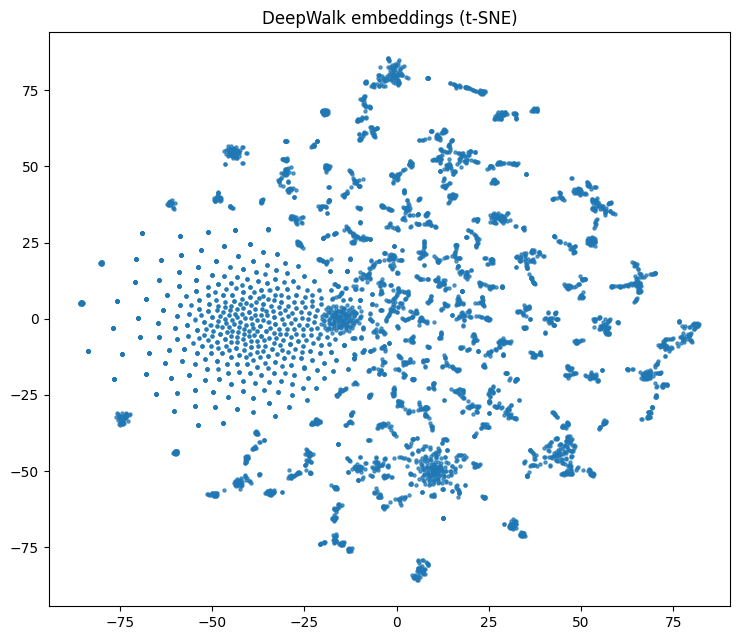

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


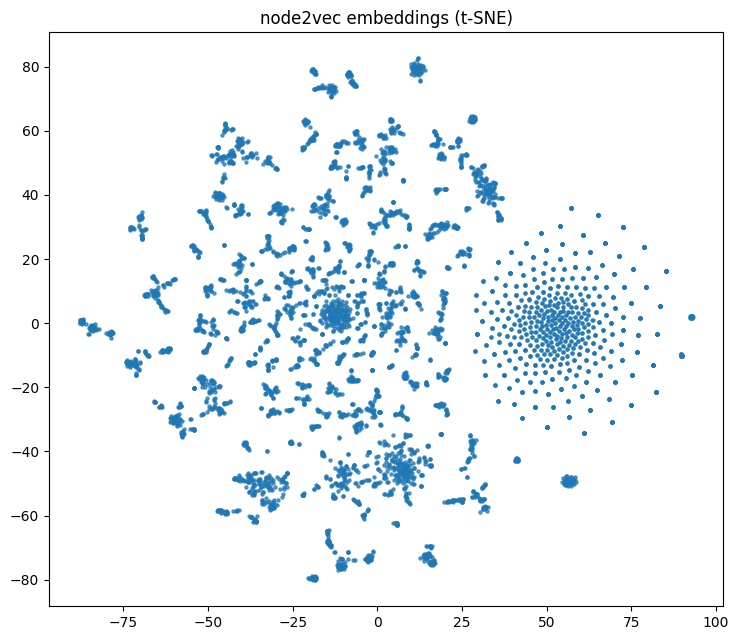

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def show_tsne(emb, title):
    Z = TSNE(n_components=2, init="pca", perplexity=30, learning_rate="auto", n_iter=1000, verbose=0).fit_transform(emb)
    plt.figure(figsize=(7.5, 6.5))
    plt.scatter(Z[:, 0], Z[:, 1], s=5, alpha=0.7)
    plt.title(title)
    plt.tight_layout()
    plt.show()

show_tsne(deepwalk_res['emb'], "DeepWalk embeddings (t-SNE)")
show_tsne(node2vec_res['emb'], "node2vec embeddings (t-SNE)")